# Benzene Price Forecasting Data Preparation

This workbook handles importing data from IHS, ICIS, and LYB PO data (azure sql queries), performing basic cleaning, merging, interpolating, and exporting.

All modeling should be done in otherwork books. This workbook should only be executed when new data is to be loaded for everyone to use. It will overwrite existing feather files

## 0.0 Notes and Explainations

This notebook uses SQL to query: 
* lyb-sql-devdacore-002.5bff9fcb8330.database.windows.net 
    * To extract the information contained in the t-code ZMRRELPO
* lyb-sql-prddacore-002.bed79ae4ef8b.database.windows.net
    * To extract ZEMA IHS data
    * To extract ZEMA ICIS data

### 0.1 Environment setup

This workbook utilizes the py37_benzene environment which can be installed via the Anaconda Prompt from your local repo sync by running:
> conda env create -f py37_benzene.yml

This .yml file is stored in scripts root directory

## 1.0 Prepare Workspace

### 1.1 Import Libraries and configure runtime parameters

In [1]:
##
# Import Basic Python DS Libraries 
import pandas as pd     # Standard data science package
import numpy as np      # Additional numerical functions
from pathlib import Path# Used to test for path existance
##
# Import Advanced Python DS Libraries
import missingno as msno    # Missing value toolbox
#from pandas_profiling import ProfileReport     # Integrated/deep reporting, resource intensive
from statsmodels.tsa.stattools import adfuller  # Statistical test for stationary data
import missingno as msno

##
# Import Database Connection Libraries
import pyodbc           # Database connector

##
# Import Plotting Libraries
import matplotlib.pyplot as plt                # Full featured plotting toolbox
import plotly.graph_objects as go               #Plotly GO toolbox
#import plotly.express as px                    # Plotly Express plotting toolbox
import plotly.io as pio                        # Addtional Controls for plotly to allow visuals within VSCode Notebook
import seaborn as sns       # Seaborn plotting toolbox

##
import datetime as dt
from datetime import date

In [2]:
# Configure Libraries
pio.renderers.default = "notebook_connected" # Configure plotly to print within VSCode environment
#pio.renderers.default = "vscode"

In [3]:
# Configure run environment
fitplotting = False

### 1.2 Import custom libraries

In [4]:
# Define location for custom functions
module_path = os.path.abspath(os.path.join('../Functions'))

# Verify it's accessible for loading
if (module_path not in sys.path) & (os.path.isdir(module_path)):
    sys.path.append(module_path)
    print('Added', module_path, 'to system paths')

elif (module_path in sys.path) & (os.path.isdir(module_path)):
    print(module_path, 'ready to be used for import')

else:
    print(module_path, 'is not a valid path')

Added c:\Users\baanders\Documents\Benzene Forecasting\Scripts\Functions to system paths


In [5]:
# Import Custom Functions
try: from multi_plot import *; print('multiplot imported successfully')
except:print('multiplot load failed')


try: from ImportTools import *; print('ImportTools loaded successfully')
except: print('ImportTools failed to load')

try: from ModelingTools import *; print("ModelingTools loaded successfully")
except: print('ModelingTools failed to load')


multiplot imported successfully
ImportTools loaded successfully
ModelingTools loaded successfully


c:\Users\baanders\Anaconda3\envs\py37_benzene\lib\site-packages\pkg_resources\__init__.py:119: PkgResourcesDeprecationWarning:

4.0.0-unsupported is an invalid version and will not be supported in a future release



### 1.3 Configure SQL Connection

In [6]:
# Setup SQL Connection
username = 'ben.anderson@lyondellbasell.com'
driver = 'ODBC Driver 17 for SQL Server'
Authentication= 'ActiveDirectoryInteractive'

# Setup SQL Server
FDA_PRD_server = 'lyb-sql-prddacore-002.bed79ae4ef8b.database.windows.net'
FDA_PRD_database = 'Source'

FDA_DEV_server = 'lyb-sql-devdacore-002.5bff9fcb8330.database.windows.net'
FDA_DEV_database = 'FinanceDa'

In [7]:
# Establish pyodbc connection to servers
if 'ODBC Driver 17 for SQL Server' in pyodbc.drivers():
    
    # Connect to PRD FinanceDa Database
    try:
        Fin_PRD_DA = pyodbc.connect('DRIVER='+driver+
                    ';SERVER='+FDA_PRD_server+
                    ';PORT=1433;DATABASE='+FDA_PRD_database+
                    ';UID='+username+
                    ';AUTHENTICATION='+Authentication
                    )
        print("FinanceDA PRD\t\tEstablished and ready to be used")
    except:
        print("FinanceDA PRD\t\tFailed")

    # Connect to DEV FinanceDa Database
    try:
        Fin_DEV_DA = pyodbc.connect('DRIVER='+driver+
                    ';SERVER='+FDA_DEV_server+
                    ';PORT=1433;DATABASE='+FDA_DEV_database+
                    ';UID='+username+
                    ';AUTHENTICATION='+Authentication
                    )
        print("FinanceDA DEV\t\tEstablished and ready to be used")
    except:
        print("FinanceDA DEV\t\tFailed")
    
    
else:
    print("Necessary Driver (ODBC Driver 17 for SQL Server), not installed, cannot connect to database ")

FinanceDA PRD		Established and ready to be used
FinanceDA DEV		Established and ready to be used


## 2.0 LYB PO Data (ZMRRELPO)

### 2.1 Define SQL Queries

Each query is defined as a variable that contains multi-line text surrounded by """

In [8]:
# Daily Futures Commodities List
ZMRRELPO_Query = """
/****** Extract all rows from Custom view that provides ZMRRELPO clone as a SQL query  ******/
SELECT [EBELN]
      ,[EBELP]
      ,[NAME1]
      ,[BEDAT]
      ,[NETWR]
      ,[MENGE]
      ,[NETPR2]
      ,[MEINS]
      ,[WAERS]
  FROM [FinanceDa].[dbo].[ZMRRELPO_benzene]
"""

### 2.2 Import and Clean SAP PO Data

In [9]:
# Extract Query into pd.DataFrame
df = pd.read_sql(ZMRRELPO_Query, Fin_DEV_DA)
print("Data successfully imported\nShape of df is ", df.shape)

# Add Source column to track origin of these rows
df['source'] = 'lyb'

# Remove any remaining lines that are above threshold (ULim)
ULim = 10 # set #/gal limit for imported data
print("There were ", str(len(df[df['NETPR2'] > ULim])), "rows greater than", str(ULim), 'before processing')
df = df[df['NETPR2'] <= ULim]
print("There were ", str(len(df[df['NETPR2'] > ULim])), "rows greater than", str(ULim), 'after processing.') 
print('\nThe statistics of the remaining numerical rows are:')
print(df.describe())

# Drop columns that are not relevent to modeling
df = df.drop(columns={'EBELN','EBELP','NAME1','NETWR','MENGE','MEINS','WAERS'})
print("\nShape of item dropped dataframe is ", df.shape)

## Give columns human readable names
df = df.rename(columns={
    'BEDAT': 'date'
    ,'NETPR2': 'LYB PO Unit Pricing'
})

# Save df as more descriptive variable name
lybpo = df.copy(deep=True)  # Deep copy is used to ensure a new dataframe is created without any basis on df
print("New dataframe lybpo created with shape:", lybpo.shape)

#  Create long format data that can be merged with other data sources
df = df.drop(columns=['source'])
df = pd.melt(df, id_vars=['date'], value_vars=['LYB PO Unit Pricing'])
lybpo_long = df.copy(deep=True)
lybpo_long = lybpo_long.rename(columns={'variable': 'description'})
print("lybpo_long created for merging. Size is ", lybpo_long.shape)

lybpo.head(5)

Data successfully imported
Shape of df is  (1049, 9)
There were  1 rows greater than 10 before processing
There were  0 rows greater than 10 after processing.

The statistics of the remaining numerical rows are:
              NETWR         MENGE       NETPR2
count  1.048000e+03  1.048000e+03  1048.000000
mean   2.546223e+06  7.922090e+05     2.642336
std    1.677323e+06  5.880888e+05     0.802991
min    3.200000e-01  1.000000e-01     0.219947
25%    1.543835e+06  4.135320e+05     2.222500
50%    2.304722e+06  8.400000e+05     2.660000
75%    3.105834e+06  1.005618e+06     3.068125
max    1.398600e+07  4.200000e+06     6.000000

Shape of item dropped dataframe is  (1048, 3)
New dataframe lybpo created with shape: (1048, 3)
lybpo_long created for merging. Size is  (1048, 3)


,date,LYB PO Unit Pricing,source
0,20220602,4.7700,lyb
1,20220614,4.4400,lyb
2,20220601,4.8500,lyb
3,20220616,4.0600,lyb
4,20220428,4.0875,lyb


## 3.0 ICIS Daily Spot (ZEMA PRD)

### 3.1 Define SQL Queries

In [10]:
# Query
ICIS_Daily_Spot_Query = """
/*** Extract ICIS Data from PRD ZEMA database for specific PRODUCT entries limited to USD% CURRENCYUNITS***/
SELECT [source]
      ,[date]
      ,[QUOTETYPE]
      ,[PRODUCT]
      ,[CURRENCYUNIT]
      ,[DESCRIPTION2]
      ,[LOW]
      ,[HIGH]
  FROM [Source].[Zema].[vtICISReports]
 WHERE (
	([PRODUCT] LIKE 'ABS%' AND [CURRENCYUNIT] LIKE 'USD%')
  	OR [PRODUCT] LIKE 'NAPHTHA%' 
		OR ([PRODUCT] = 'BENZENE' AND [CURRENCYUNIT] = 'USD/US gal')
		OR ([PRODUCT] IN ('CYCLOHEXANE', 'PROPYLENE OXIDE') AND [CURRENCYUNIT] = 'US CTS/US gal')
  	OR ([PRODUCT] IN ('CRUDE C4', 'CRUDE C4 FORMULA', 'ETHYLENE', 'STYRENE', 'STYRENE MONOMER') AND [CURRENCYUNIT] LIKE 'USD%')
	)
"""

### 3.2 Import and Clean ICIS Weekly Spot Data

In [11]:
# Extract Query into pd.DataFrame
df = pd.read_sql(ICIS_Daily_Spot_Query, Fin_PRD_DA)
print("Data successfully imported\nShape imported of dataframe is ", df.shape)

#  Melt high and low values into row values
df = pd.melt(df, id_vars=['source','date','QUOTETYPE','PRODUCT','CURRENCYUNIT','DESCRIPTION2'], value_vars=['HIGH','LOW'])
print("Shape of melted dataframe is ", df.shape)

# Combine descriptor values into a column and drop originating values
df['description'] = df[['PRODUCT','variable', 'QUOTETYPE', 'CURRENCYUNIT','DESCRIPTION2']].agg('-'.join, axis=1)
df = df.drop(columns={'PRODUCT', 'QUOTETYPE', 'CURRENCYUNIT','DESCRIPTION2', 'variable','source'})
print("Shape of combined and dropped dataframe is ", df.shape)

# Reconcile any non-numeric value entries
df = (df.drop('value', axis=1).join(df['value'].apply(pd.to_numeric, errors='coerce')))
df = pd.DataFrame(df)
print("Shape of numerically corrected dataframe is ", df.shape)

# Create a permanent copy of the long format data frame to allow for easy merging of data sources
icis_long = df.copy(deep=True)
print("icis_long created, can be used later when merging with other sources. Size is ", icis_long.shape)

# Pivot data to create a column for each feature
df = pd.pivot_table(df, index='date', columns='description', values='value', dropna=False)
print("Shape of pivoted dataframe is ", df.shape)

# Add source column to track origin
df['source'] = 'ICIS'

# Save df as more descriptive variable name
icis = df.copy(deep=True)  # Deep copy is used to ensure a new dataframe is created without any basis on df
print("New dataframe icis created with shape:", icis.shape,"\n\n Top 5 rows look like:")
icis.head(20)

Data successfully imported
Shape imported of dataframe is  (4524, 8)
Shape of melted dataframe is  (9048, 8)
Shape of combined and dropped dataframe is  (9048, 3)
Shape of numerically corrected dataframe is  (9048, 3)
icis_long created, can be used later when merging with other sources. Size is  (9048, 3)
Shape of pivoted dataframe is  (390, 102)
New dataframe icis created with shape: (390, 103) 

 Top 5 rows look like:


description,"ABS GENERAL PURPOSE, INJECTION GRADE-HIGH-SPOT-USD/tonne-CFR ASIA NE CLOSE-WEIGHTED RANGE 0-4 WEEKS","ABS GENERAL PURPOSE, INJECTION GRADE-HIGH-SPOT-USD/tonne-CFR ASIA SE CLOSE-WEIGHTED RANGE 0-4 WEEKS","ABS GENERAL PURPOSE, INJECTION GRADE-HIGH-SPOT-USD/tonne-CFR INDIA MAIN PORTS CLOSE-WEIGHTED RANGE 0-4 WEEKS","ABS GENERAL PURPOSE, INJECTION GRADE-LOW-SPOT-USD/tonne-CFR ASIA NE CLOSE-WEIGHTED RANGE 0-4 WEEKS","ABS GENERAL PURPOSE, INJECTION GRADE-LOW-SPOT-USD/tonne-CFR ASIA SE CLOSE-WEIGHTED RANGE 0-4 WEEKS","ABS GENERAL PURPOSE, INJECTION GRADE-LOW-SPOT-USD/tonne-CFR INDIA MAIN PORTS CLOSE-WEIGHTED RANGE 0-4 WEEKS",BENZENE-HIGH-CONTRACT-USD/US gal-FOB USG MONTH CONTRACT SURVEY,BENZENE-HIGH-SPOT-USD/US gal-DDP USG CLOSING VALUE CURRENT MONTH,BENZENE-HIGH-SPOT-USD/US gal-DDP USG CLOSING VALUE NEXT MONTH,BENZENE-HIGH-SPOT-USD/US gal-DDP USG FULL MARKET RANGE CURRENT MONTH,...,STYRENE-LOW-SPOT-USD/tonne-FOB CHINA CLOSING VALUE 2-6 WEEKS,STYRENE-LOW-SPOT-USD/tonne-FOB ROTTERDAM BID/OFFER RANGE CURRENT MONTH,STYRENE-LOW-SPOT-USD/tonne-FOB ROTTERDAM CLOSING VALUE CURRENT MONTH,STYRENE-LOW-SPOT-USD/tonne-FOB ROTTERDAM CLOSING VALUE NEXT MONTH,STYRENE-LOW-SPOT-USD/tonne-FOB ROTTERDAM FULL MARKET RANGE CURRENT MONTH,STYRENE-LOW-SPOT-USD/tonne-FOB ROTTERDAM FULL MARKET RANGE NEXT MONTH,STYRENE-LOW-SPOT-USD/tonne-FOB SOUTH KOREA CLOSE-WEIGHTED RANGE 2-6 WEEKS,STYRENE-LOW-SPOT-USD/tonne-FOB SOUTH KOREA CLOSING VALUE 2-6 WEEKS,STYRENE-LOW-SPOT-USD/tonne-FOB SOUTH KOREA FULL MARKET RANGE 2-6 WEEKS,source
date,,,,,,,,,,,,,,,,,,,,,
2020-11-13,NaN,NaN,NaN,NaN,NaN,NaN,1.55,2.00,2.02,1.77,...,NaN,830.0,1000.0,1000.0,925.0,880.0,NaN,NaN,NaN,ICIS
2020-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ICIS
2020-11-20,2450.0,2300.0,2300.0,2300.0,2200.0,2200.0,1.55,1.96,2.01,2.08,...,NaN,925.0,910.0,890.0,950.0,890.0,1050.0,1050.0,1050.0,ICIS
2020-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1050.0,NaN,NaN,ICIS
2020-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,970.0,NaN,NaN,ICIS
2020-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,970.0,NaN,NaN,ICIS
2020-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,970.0,NaN,NaN,ICIS
2020-11-27,2500.0,2300.0,2300.0,2300.0,2200.0,2200.0,1.55,2.06,2.10,2.10,...,NaN,880.0,880.0,890.0,880.0,910.0,980.0,980.0,970.0,ICIS
2020-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,980.0,NaN,NaN,ICIS


## 4.0 IHS Weekly Pricing (ZEMA PRD)

### 4.1 Define SQL Queries

In [12]:
IHS_Weekly_Query = """
/****** Extract IHS Data from PRD ZEMA database for specific PRODUCT entries limited to UNIT to ensure only one entry per PRODUCT  ******/
SELECT [date]
      ,[CONCEPT]
      ,[GEOGRAPHY]
      ,[GRADE]
      ,[PRICE]
      ,[PRODUCT]
      ,[TERMS]
      ,[UNIT]
  FROM [Source].[Zema].[vtIHSChemicalPriceWsWly]
  WHERE ([PRODUCT] in ('Benzene','Toluene','Xylenes (mixed)') AND [UNIT] = 'Cents per Gallon')
		OR 
		([PRODUCT] in ('Ethylene','Styrene','Paraxylene','Polystyrene (PS)') 
			AND ([UNIT] = 'Cents per Pound'))
		OR
		([PRODUCT] in ('Expandable Polystyrene (EPS)','Paraxylene') 
			AND ([UNIT] = 'US$ per Metric Ton'))
"""

### Import and Clean IHS Weekly data

In [13]:
# Extract Query into pd.DataFrame
df = pd.read_sql(IHS_Weekly_Query, Fin_PRD_DA)
print("Data successfully imported\nShape imported of dataframe is ", df.shape)

# Combine descriptor values into a column and drop originating values
df['description'] = df[['PRODUCT','CONCEPT', 'GRADE', 'UNIT','TERMS','GEOGRAPHY']].agg('-'.join, axis=1)
df = df.drop(columns={'PRODUCT','CONCEPT', 'GRADE', 'UNIT','TERMS','GEOGRAPHY'})
print("Shape of combined and dropped dataframe is ", df.shape)

# Reconcile any non-numeric value entries
df = (df.drop('PRICE', axis=1).join(df['PRICE'].apply(pd.to_numeric, errors='coerce')))
df = pd.DataFrame(df)
print("Shape of numerically corrected dataframe is ", df.shape)

# Create a permanent copy of the long format data frame to allow for easy merging of data sources
ihs_long = df.copy(deep=True)
ihs_long = ihs_long.rename(columns={'PRICE': 'value'})
print("ihs_long created, can be used later when merging with other sources. Size is ", ihs_long.shape)

# Pivot data to create a column for each dataset
df = pd.pivot_table(df, index='date', columns='description', values='PRICE', dropna=False)
print("Shape of pivoted dataframe is ", df.shape)

# Add source column to track origin
df['source'] = 'IHS'

# Save df as more descriptive variable name
ihs = df.copy(deep=True)  # Deep copy is used to ensure a new dataframe is created without any basis on df
print("New dataframe ihs created with shape:", ihs.shape,"\n\n Top 5 rows look like:")
ihs.head(5)

Data successfully imported
Shape imported of dataframe is  (155787, 8)
Shape of combined and dropped dataframe is  (155787, 3)
Shape of numerically corrected dataframe is  (155787, 3)
ihs_long created, can be used later when merging with other sources. Size is  (155787, 3)
Shape of pivoted dataframe is  (395, 52)
New dataframe ihs created with shape: (395, 53) 

 Top 5 rows look like:


description,"Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America","Benzene-Spot, Current Month, Low-N/A-Cents per Gallon-FOB Houston, TX-North America","Benzene-Spot, Next Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America","Benzene-Spot, Next Month, Low-N/A-Cents per Gallon-FOB Houston, TX-North America","Ethylene-Co-Product Integrated Production Cash Cost Naphtha Feed, Current Month, Spot Co-Product Credits-N/A-Cents per Pound-US Gulf Coast-North America","Ethylene-Prod Cash Cost Butane Feed, Current Month, Spot Co-Product Credits-N/A-Cents per Pound-US Gulf Coast-North America","Ethylene-Prod Cash Cost Gas Oil Feed, Current Month, Spot Co-Product Credits-N/A-Cents per Pound-US Gulf Coast-North America","Ethylene-Prod Cash Cost Naphtha Feed, Current Month, Spot Co-Product Credits-N/A-Cents per Pound-US Gulf Coast-North America","Ethylene-Prod Cash Cost Propane Feed, Current Month, Spot Co-Product Credits-N/A-Cents per Pound-US Gulf Coast-North America","Ethylene-Prod Cash Cost Purity Ethane Feed, Current Month, Spot Co-Product Credits-N/A-Cents per Pound-US Gulf Coast-North America",...,"Toluene-Spot, Current Month, High-Nitration Grade-Cents per Gallon-FOB Houston, TX-North America","Toluene-Spot, Current Month, Low-Commercial Grade-Cents per Gallon-FOB Houston, TX-North America","Toluene-Spot, Current Month, Low-Nitration Grade-Cents per Gallon-FOB Houston, TX-North America","Toluene-Spot, Next Month, High-Nitration Grade-Cents per Gallon-FOB Houston, TX-North America","Toluene-Spot, Next Month, Low-Nitration Grade-Cents per Gallon-FOB Houston, TX-North America","Xylenes (mixed)-Spot, Current Month, High-N/A-Cents per Gallon-Houston, TX-North America","Xylenes (mixed)-Spot, Current Month, Low-N/A-Cents per Gallon-Houston, TX-North America","Xylenes (mixed)-Spot, Next Month, High-N/A-Cents per Gallon-Houston, TX-North America","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America",source
date,,,,,,,,,,,,,,,,,,,,,
2014-12-25,222.63,218.56,225.00,223.50,12.196,7.469,24.432,19.158,6.469,9.424,...,241.13,207.5,219.56,241.00,219.69,230.75,206.25,230.75,208.00,IHS
2015-01-01,217.67,215.67,227.08,220.75,10.273,7.061,15.138,17.163,4.776,9.576,...,218.17,200.0,215.00,227.00,213.67,209.67,199.33,218.33,201.67,IHS
2015-01-08,203.80,201.80,211.45,208.35,8.907,6.478,32.287,15.204,4.059,9.906,...,204.10,195.8,199.45,214.40,200.40,206.50,195.65,209.40,197.60,IHS
2015-01-15,198.95,193.85,203.65,197.80,9.180,9.126,29.999,16.221,4.250,10.618,...,191.80,185.6,191.40,202.80,190.00,196.00,186.30,204.20,187.80,IHS
2015-01-22,210.25,208.00,212.00,210.00,9.061,10.780,29.369,15.845,6.082,10.181,...,198.06,184.0,187.88,201.75,187.88,201.25,188.63,203.00,190.75,IHS


## 5.0 Platts Pricing (ZEMA PRD)

### 5.1 Define SQL Queries

In [14]:

plattshf = """
SELECT [date]
      ,[HIGHLOW2]
      ,[AVERAGE]
      ,[CLOSE]
      ,[HIGH]
      ,[LOCATION]
      ,[LOW]
  FROM [Source].[Zema].[vtPlattsHf]
  WHERE [location] like 'Benzene%(USD/MT)'
  OR [LOCATION] LIKE 'Styrene%(USD/MT)'
  OR [LOCATION] LIKE 'Platts%(USD/MT)'
"""

plattsal = """
SELECT [date]
      ,[HIGHLOW2]
      ,[AVERAGE]
      ,[CLOSE]
      ,[HIGH]
      ,[LOCATION]
      ,[LOW]
      ,[PLATTSCODE]
  FROM [Source].[Zema].[vtPlattsAl]
  WHERE [LOCATION] LIKE '%Weekly%'
"""

plattsho = """
SELECT [date]
      ,[HIGHLOW2]
      ,[AVERAGE]
      ,[CLOSE]
      ,[HIGH]
      ,[LOCATION]
      ,[LOW]
  FROM [Source].[Zema].[vtPlattsHo]
 WHERE [LOCATION] LIKE 'Ethane%(USC/LB)'
  OR [LOCATION] LIKE 'Global%(USD/MT)'
  OR [LOCATION] LIKE 'Raffinate-1%NWE Weekly%(USD/MT)'
"""

plattshs = """
SELECT [date]
      ,[HIGHLOW2]
      ,[AVERAGE]
      ,[CLOSE]
      ,[HIGH]
      ,[LOCATION]
      ,[LOW]
  FROM [Source].[Zema].[vtPlattsHs]
  WHERE [LOCATION] like '%naphtha%(USD/MT)'
  """

FedExRate = """
  SELECT [date]
      ,[EXCHANGERATE]
      ,[UNIT]
  FROM [Source].[Zema].[vtUsFedForExcRates]
  """


### 5.2 Import and Clean Platts data

In [15]:
hf = SQLImport(FDA_PRD_server, FDA_PRD_database, username, plattshf)
hf_long, hf_wide = platts_cleaning(hf)

FinanceDA PRD		Established 
Query Extraction	Complete
Extracted data has size: (74763, 7)
Original shape:	 (74763, 7)
Long shape:	 (373815, 3)
Pivot shape:	 (1906, 400)


In [16]:
al = SQLImport(FDA_PRD_server, FDA_PRD_database, username, plattsal)
al_long, al_wide = platts_cleaning(al)

FinanceDA PRD		Established 
Query Extraction	Complete
Extracted data has size: (1146, 8)
Original shape:	 (1146, 8)
Long shape:	 (5730, 3)
Pivot shape:	 (380, 15)


In [17]:
ho = SQLImport(FDA_PRD_server, FDA_PRD_database, username, plattsho)
ho_long, ho_wide = platts_cleaning(ho)

FinanceDA PRD		Established 
Query Extraction	Complete
Extracted data has size: (7733, 7)
Original shape:	 (7733, 7)
Long shape:	 (38665, 3)
Pivot shape:	 (1885, 25)


In [18]:
hs = SQLImport(FDA_PRD_server, FDA_PRD_database, username, plattshs)
hs_long, hs_wide = platts_cleaning(hs)

FinanceDA PRD		Established 
Query Extraction	Complete
Extracted data has size: (463, 7)
Original shape:	 (463, 7)
Long shape:	 (2315, 3)
Pivot shape:	 (448, 10)


In [19]:
fedex = SQLImport(FDA_PRD_server, FDA_PRD_database, username, FedExRate)
fedex_long, fedex_wide = fedex_cleaning(fedex)

FinanceDA PRD		Established 
Query Extraction	Complete
Extracted data has size: (39468, 3)
Original shape:	 (39468, 3)
Index(['date', 'value', 'description'], dtype='object')
Pivot shape:	 (1713, 23)


## 6.0 FRED Data (Web Scrape)

In [20]:
# Define API key to access Fred Data
fred_api_key = 'd19d462c8ce42c8e0a58db98eb416e0c'

In [21]:
# Define Fred data to import
series = { 
    'DHHNGSP':'Henry Hub Natural Gas Spot Price' ,
    'DCOILBRENTEU': 'Crude Oil Prices Brent  Europe',
    'DCOILWTICO': 'Crude Oil Prices West Texas Intermediate (WTI) Cushing Oklahoma', 
    'PNGASJPUSDM': 'Global price of LNG Asia', 
    'DJFUELUSGULF': 'Kerosene Type Jet Fuel Prices US Gulf Coast', 
    'DDFUELUSGULF' : 'Ultra Low Sulfur No 2 Diesel Fuel Prices US Gulf Coast' , 
    'DGASUSGULF':'Conventional Gasoline Prices US Gulf Coast Regular'}

In [22]:
fred_wide = multi_fred(series, fred_api_key)

In [23]:
fred_long = fred_wide.reset_index().melt(id_vars='index').dropna(axis=0).rename(columns={'index':'date', 'variable':'description'})
fred_long

,date,description,value
2889,1997-01-07,Henry Hub Natural Gas Spot Price,3.820
2890,1997-01-08,Henry Hub Natural Gas Spot Price,3.800
2891,1997-01-09,Henry Hub Natural Gas Spot Price,3.610
2892,1997-01-10,Henry Hub Natural Gas Spot Price,3.920
2893,1997-01-13,Henry Hub Natural Gas Spot Price,4.000
...,...,...,...
67488,2022-07-12,Conventional Gasoline Prices US Gulf Coast Reg...,3.226
67489,2022-07-13,Conventional Gasoline Prices US Gulf Coast Reg...,3.194
67490,2022-07-14,Conventional Gasoline Prices US Gulf Coast Reg...,3.149
67491,2022-07-15,Conventional Gasoline Prices US Gulf Coast Reg...,3.096


## 7.0 ICIS Data

### 7.1 Excel

Non-prefered. API connection is prefered.

In [24]:
#icis_path = '../../Data/ICIS Excel/'
#icis_file = 'ICIS Naphtha Pricing with Plugin.xlsx'
#naphtha_w, naphtha_l = icis_excel_import(icis_path+icis_file, sheet='Sheet1')
#naphtha_l.head(5)
#naphtha_w.head(5)

### 7.2 API

In [31]:
icis_data = {
    "http://iddn.icis.com/series/petchem/6002006" : 'Naphtha Reforming FOB US Assessment Barges Spot 4 Weeks Closing Value Daily (Mid) : US CTS/US gal',
    "http://iddn.icis.com/series/petchem/6002007" : 'Naphtha FOB Singapore Assessment Spot Closing Value Daily (Mid) : USD/bbl'
}

icis_data = icis_api_series_dict(icis_data, 
    'ben.anderson@lyondellbasell.com', 
    'MyICISPassword1234',
    constraints='''
        <compare field="c:series-order" op="ge" value="2015-01-01"/>
        '''
    )

icis_data

,date,value,description
0,2015-01-02T00:00:00Z,120.25,Naphtha Reforming FOB US Assessment Barges Spo...
1,2015-01-05T00:00:00Z,116.5,Naphtha Reforming FOB US Assessment Barges Spo...
2,2015-01-06T00:00:00Z,116.25,Naphtha Reforming FOB US Assessment Barges Spo...
3,2015-01-07T00:00:00Z,112.75,Naphtha Reforming FOB US Assessment Barges Spo...
4,2015-01-08T00:00:00Z,115,Naphtha Reforming FOB US Assessment Barges Spo...
...,...,...,...
3835,2022-07-18T00:00:00Z,207.75,Naphtha Reforming FOB US Assessment Barges Spo...
3836,2022-07-19T00:00:00Z,212.75,Naphtha Reforming FOB US Assessment Barges Spo...
3837,2022-07-20T00:00:00Z,212.5,Naphtha Reforming FOB US Assessment Barges Spo...
3838,2022-07-21T00:00:00Z,199,Naphtha Reforming FOB US Assessment Barges Spo...


## 10.0 Data Set Merging

### 10.1 Validate LYB Data

In [27]:
# Ensure column date is correctly set to datetime
lybpo_long['date'] = pd.to_datetime(lybpo_long['date'])

# Print lybpo_long to verify datasource
lybpo_long.head(5)

,date,description,value
0,2022-06-02,LYB PO Unit Pricing,4.7700
1,2022-06-14,LYB PO Unit Pricing,4.4400
2,2022-06-01,LYB PO Unit Pricing,4.8500
3,2022-06-16,LYB PO Unit Pricing,4.0600
4,2022-04-28,LYB PO Unit Pricing,4.0875


### 10.2 Validate ICIS Data

In [28]:
# Ensure column date is correctly set to datetime
icis_long['date'] = pd.to_datetime(icis_long['date'])

# Print icis_long to verify datasource
icis_long.head(5)


,date,description,value
0,2021-01-04,STYRENE-HIGH-SPOT-USD/tonne-CFR CHINA CLOSE-WE...,855.0
1,2021-01-11,STYRENE-HIGH-SPOT-USD/tonne-CFR CHINA CLOSE-WE...,920.0
2,2021-01-18,STYRENE-HIGH-SPOT-USD/tonne-CFR CHINA CLOSE-WE...,940.0
3,2021-01-25,STYRENE-HIGH-SPOT-USD/tonne-CFR CHINA CLOSE-WE...,945.0
4,2021-02-01,STYRENE-HIGH-SPOT-USD/tonne-CFR CHINA CLOSE-WE...,985.0


### 10.3 Validate IHS Data

In [29]:
# Ensure column date is correctly set to datetime
ihs_long['date'] = pd.to_datetime(ihs_long['date'])

# Print ihs_long to verify datasource
ihs_long.head(5)

,date,description,value
0,2016-09-29,"Xylenes (mixed)-Spot, Next Month, High-N/A-Cen...",219.40
1,2016-09-29,"Xylenes (mixed)-Spot, Next Month, Low-N/A-Cent...",210.55
2,2016-09-29,"Paraxylene-Spot, Current Month, High-N/A-US$ p...",747.00
3,2016-09-29,"Paraxylene-Spot, Current Month, Low-N/A-US$ pe...",723.00
4,2016-09-29,"Paraxylene-Spot, Next Month, High-N/A-US$ per ...",747.00


### 10.4 Merge and Pivot Data

#### 10.4.1 Merge Data Sources

In [32]:
# Append all data sources (from long format) to a single combined source
combined_long = pd.concat([lybpo_long, icis_long, ihs_long, ho_long, hf_long, al_long, hs_long, fedex_long, fred_long, icis_data], ignore_index=True)
print("lyb", lybpo_long.shape)
print("icis", icis_long.shape)
print("ihs", ihs_long.shape)
print('ho', ho_long.shape)
print('hf', hf_long.shape)
print('al', al_long.shape)
print('hs', hs_long.shape)
print('fedex', fedex_long.shape)
print('fred', fred_long.shape)
print('icisi api', icis_data.shape)
print("combined", combined_long.shape)

print("There are ", len(pd.unique(combined_long['description'])), "unique features and", len(pd.unique(combined_long['date'])), "unique dates in the combined dataset")

combined_long.head(5)

lyb (1048, 3)
icis (9048, 3)
ihs (155787, 3)
ho (38665, 3)
hf (373815, 3)
al (5730, 3)
hs (2315, 3)
fedex (39468, 3)
fred (46156, 3)
naphtha us (3840, 3)
combined (675872, 3)
There are  637 unique features and 11448 unique dates in the combined dataset


,date,description,value
0,2022-06-02 00:00:00,LYB PO Unit Pricing,4.77
1,2022-06-14 00:00:00,LYB PO Unit Pricing,4.44
2,2022-06-01 00:00:00,LYB PO Unit Pricing,4.85
3,2022-06-16 00:00:00,LYB PO Unit Pricing,4.06
4,2022-04-28 00:00:00,LYB PO Unit Pricing,4.0875


#### 10.4.2 Pivot Combined Data

In [33]:
combined_long.date= pd.to_datetime(combined_long.date, utc=True)
combined_long.value = pd.to_numeric(combined_long.value, errors='coerce')
combined_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675872 entries, 0 to 675871
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   date         675732 non-null  datetime64[ns, UTC]
 1   description  675872 non-null  object             
 2   value        602293 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 15.5+ MB


In [34]:
# Create wide format (pivot_table) of combined data. Row = date, column = feature
combined = combined_long.pivot_table(index='date', columns='description', values='value', aggfunc=np.sum)
print("The shape of the pivoted dataset is", combined.shape, "and the first 5 rows look like:")

# Flatten the indices that are generated when utilizing the pivot_table function
#combined=combined.reset_index(drop=False)   

# Remove the name from the remaining index column
combined = combined.rename_axis(None, axis=1)

# Ensure that the index column is datetime format
# This line will not work if the 2 above are active. But no reason to drop the index column at this time.
#combined.index = pd.to_datetime(combined.index)
#combined = pd.DatetimeIndex(combined.index)
#print(type(combined.index))
#combined.index = pd.to_datetime(combined.index, utc=True)
#print(combined.info())

# Print the top 5 lines to ensure the new combined data table looks correct
combined.head(5)

The shape of the pivoted dataset is (9527, 637) and the first 5 rows look like:


,"ABS GENERAL PURPOSE, INJECTION GRADE-HIGH-SPOT-USD/tonne-CFR ASIA NE CLOSE-WEIGHTED RANGE 0-4 WEEKS","ABS GENERAL PURPOSE, INJECTION GRADE-HIGH-SPOT-USD/tonne-CFR ASIA SE CLOSE-WEIGHTED RANGE 0-4 WEEKS","ABS GENERAL PURPOSE, INJECTION GRADE-HIGH-SPOT-USD/tonne-CFR INDIA MAIN PORTS CLOSE-WEIGHTED RANGE 0-4 WEEKS","ABS GENERAL PURPOSE, INJECTION GRADE-LOW-SPOT-USD/tonne-CFR ASIA NE CLOSE-WEIGHTED RANGE 0-4 WEEKS","ABS GENERAL PURPOSE, INJECTION GRADE-LOW-SPOT-USD/tonne-CFR ASIA SE CLOSE-WEIGHTED RANGE 0-4 WEEKS","ABS GENERAL PURPOSE, INJECTION GRADE-LOW-SPOT-USD/tonne-CFR INDIA MAIN PORTS CLOSE-WEIGHTED RANGE 0-4 WEEKS",AUD/USD,BENZENE-HIGH-CONTRACT-USD/US gal-FOB USG MONTH CONTRACT SURVEY,BENZENE-HIGH-SPOT-USD/US gal-DDP USG CLOSING VALUE CURRENT MONTH,BENZENE-HIGH-SPOT-USD/US gal-DDP USG CLOSING VALUE NEXT MONTH,...,USD/SGD,USD/THB,USD/TWD,USD/VEB,USD/ZAR,Ultra Low Sulfur No 2 Diesel Fuel Prices US Gulf Coast,"Xylenes (mixed)-Spot, Current Month, High-N/A-Cents per Gallon-Houston, TX-North America","Xylenes (mixed)-Spot, Current Month, Low-N/A-Cents per Gallon-Houston, TX-North America","Xylenes (mixed)-Spot, Next Month, High-N/A-Cents per Gallon-Houston, TX-North America","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America"
date,,,,,,,,,,,,,,,,,,,,,
1986-01-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-06 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-07 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-08 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 10.4.3 Visualize Missing Data
msno.matrix(df)

<AxesSubplot:>

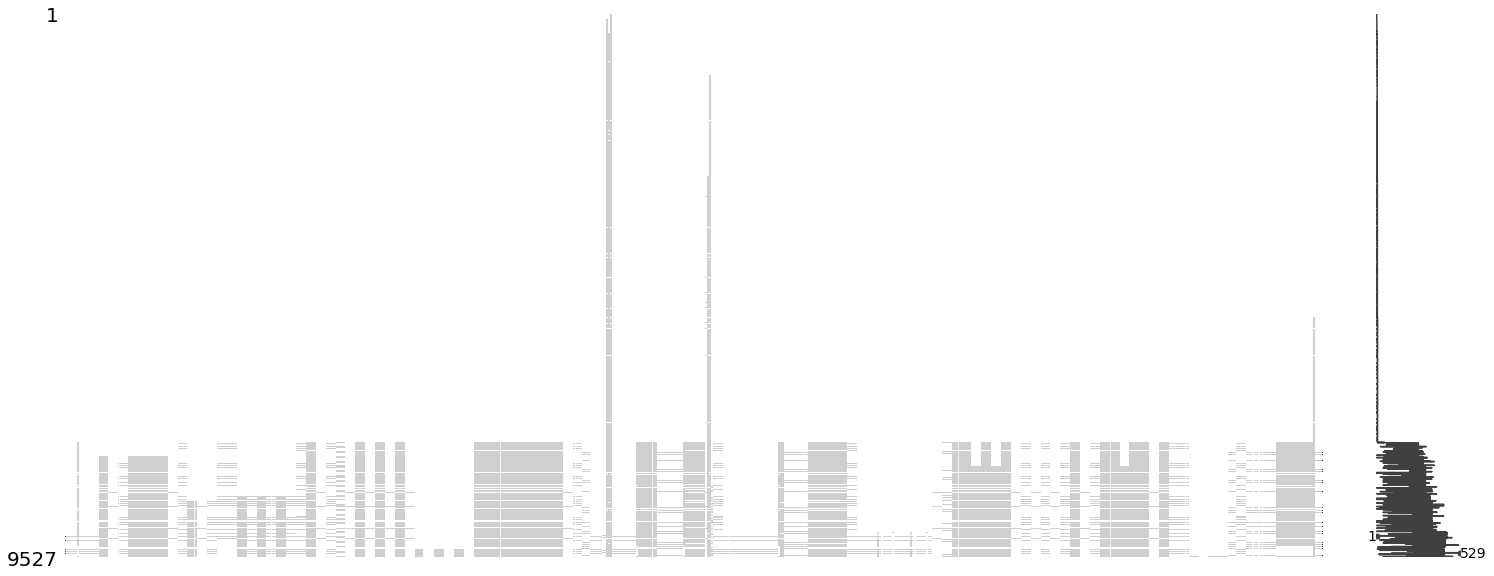

In [35]:
# Visualize dataset NaN values
msno.matrix(combined)
#multi_plot(combined, "Original Uninterpolated Data")

### 10.5 Interpolate Missing Values

Standard Scikit models do not tolerate missing values (sparse data). We'll use various methods of interpolation to fill those values in and validate that we have no more missing values.

Pandas provides a variety of interpolation methods and we'll use each to create a new data source for each type. These will be saved so that in modeling all users can start with the same stored data and ensure comparative accuracy.

In [36]:
# Define global limit for NaN fills
FillMax = 10

#### 10.5.1 Pad (Fill Foward)

In [37]:
# Perform ffill (forward filling)  of the combined dataset to fill NaN values from the last known value
    # Method = ffil : Fill forward
    # Axis = 0 : Column-wise
    # limit = 10 : Do not fill more than 10 NaN values. 
    # limit_area = None : perform end interpolations for NaN values at the top and bottom of columns

print('There are', combined.isna().sum().sum(), "missing values in the dataframe prior to interpolation")
combined_ffill = combined.interpolate(method='pad',axis=0, limit=None, limit_direction='forward')
print('There are', combined_ffill.isna().sum().sum(), "missing values in the dataframe after to interpolation")
if fitplotting:
    msno.matrix(combined_ffill)
    multi_plot(combined_ffill, "Forward Fill")

There are 5531212 missing values in the dataframe prior to interpolation
There are 5061022 missing values in the dataframe after to interpolation


#### 10.5.1 Linear Interpolation

In [38]:
# Perform linear interpolation of the combined dataset to fill NaN values.
    # Method = Linear : Linear interpolation
    # Axis = 0 : Column-wise
    # limit = 10 : Do not fill more than 10 NaN values. 
    # limit_direction = 'both' : interpolate from both sides 
    # limit_arear = None : perform end interpolations for NaN values at the top and bottom of columns

print('There are', combined.isna().sum().sum(), "missing values in the dataframe prior to interpolation")
combined_linear = combined.interpolate(method='linear',axis=0, limit=FillMax, limit_direction='both', limit_area='Inside')
print('There are', combined_linear.isna().sum().sum(), "missing values in the dataframe after to interpolation")
if fitplotting:
    msno.matrix(combined_linear)
    multi_plot(combined_linear, "Linear Interpolation")

There are 5531212 missing values in the dataframe prior to interpolation
There are 5090375 missing values in the dataframe after to interpolation


#### 10.5.2 Polynomial Interpolation

In [39]:
# Perform polynomial interpolation of the combined dataset to fill NaN values.
    # Method = polynomial : polynomial interpolation
    # Order = 3 : Allow a 2nd order polynomial fit 
    # Axis = 0 : Column-wise
    # limit = 10 : Do not fill more than 10 NaN values. 
    # limit_direction = 'both' : interpolate from both sides 
    # limit_arear = None : perform end interpolations for NaN values at the top and bottom of columns
#print('There are', combined.isna().sum().sum(), "missing values in the dataframe prior to interpolation")
#combined_poly2 = combined.interpolate(method='polynomial',order=2,axis=0, limit=FillMax, limit_direction='both', limit_area='Inside')
#print('There are', combined_poly2.isna().sum().sum(), "missing values in the dataframe after to interpolation")
#if fitplotting:
#    msno.matrix(combined_poly2)
#    multi_plot(combined_poly2, "2nd Order Polynomial Interpolation")

In [40]:
# Perform polynomial interpolation of the combined dataset to fill NaN values.
    # Method = polynomial : polynomial interpolation
    # Order = 4 : Allow a 3th power polynomial fit (scientifically few things are higher dimension than 3rd order, but will test fit later)
    # Axis = 0 : Column-wise
    # limit = 10 : Do not fill more than 10 NaN values. 
    # limit_direction = 'both' : interpolate from both sides 
    # limit_arear = None : perform end interpolations for NaN values at the top and bottom of columns
#print('There are', combined.isna().sum().sum(), "missing values in the dataframe prior to interpolation")
#combined_poly3 = combined.interpolate(method='polynomial',order=3,axis=0, limit=FillMax, limit_direction='both', limit_area='Inside')
#print('There are', combined_poly3.isna().sum().sum(), "missing values in the dataframe after to interpolation")
#if fitplotting:
#    msno.matrix(combined_poly3)
#    multi_plot(combined_poly3, "3rd Order Polynomial Interpolation")

#### 10.5.3 Spline Interpolation

In [41]:
# Perform Spline interpolation of the combined dataset to fill NaN values.
    # Method = spline : spline interpolation
    # Order = 3 : Allow a cubic spline fit (scientifically few things are higher dimension than 3rd order)
    # Axis = 0 : Column-wise
    # limit = 10 : Do not fill more than 10 NaN values. 
    # limit_direction = 'both' : interpolate from both sides 
    # limit_arear = None : perform end interpolations for NaN values at the top and bottom of columns

#print('There are', combined.isna().sum().sum(), "missing values in the dataframe prior to interpolation")
#combined_spline2 = combined.interpolate(method='spline', order=2, axis=0, limit=FillMax, limit_direction='both', limit_area='Inside')
#print('There are', combined_spline2.isna().sum().sum(), "missing values in the dataframe after to interpolation")
#if fitplotting:
#    msno.matrix(combined_spline2)
#    multi_plot(combined_spline2, "2nd Order Spline Interpolation")

In [42]:
# Perform Spline interpolation of the combined dataset to fill NaN values.
    # Method = spline : spline interpolation
    # Order = 4 : Allow a 4th order spline fit (scientifically few things are higher dimension than 3rd order, but including for verification)
    # Axis = 0 : Column-wise
    # limit = 10 : Do not fill more than 10 NaN values. 
    # limit_direction = 'both' : interpolate from both sides 
    # limit_arear = None : perform end interpolations for NaN values at the top and bottom of columns

#print('There are', combined.isna().sum().sum(), "missing values in the dataframe prior to interpolation")
#combined_spline3 = combined.interpolate(method='spline', order=3, axis=0, limit=FillMax, limit_direction='both', limit_area='Inside')
#print('There are', combined_spline3.isna().sum().sum(), "missing values in the dataframe after to interpolation")
#if fitplotting:
#    msno.matrix(combined_spline3)
#    multi_plot(combined_spline3, "3rd Order Spline Interpolation")

#### 10.5.4 Piecewise_polynomial Polynomial

In [43]:
# Perform piecewise_polynomial interpolation of the combined dataset to fill NaN values.
    # Method = piecewise_polynomial : piecewise_polynomial interpolation
    # Axis = 0 : Column-wise
    # limit = None : Fill all NaN regardless of how many in a row
    # limit_direction = 'both' : interpolate from both sides 
    # limit_arear = None : perform end interpolations for NaN values at the top and bottom of columns

#print('There are', combined.isna().sum().sum(), "missing values in the dataframe prior to interpolation")
##combined_pwp = combined.interpolate(method='piecewise_polynomial', order=2, axis=0, limit=FillMax, limit_direction='both', limit_area='Inside')
#print('There are', combined_pwp.isna().sum().sum(), "missing values in the dataframe after to interpolation")
#if fitplotting:
#    msno.matrix(combined_pwp)
#    multi_plot(combined_pwp, "Piecewise Polynomial Interpolation")

#### 10.5.5 Akima Interpolation

In [44]:
# Perform Akima interpolation of the combined dataset to fill NaN values.
    # Method = akima : akima interpolation
    # Order = 3 : Allow a cubic spline fit (scientifically few things are higher dimension than 3rd order)
    # Axis = 0 : Column-wise
    # limit = 10 : Do not fill more than 10 NaN values. 
    # limit_direction = 'both' : interpolate from both sides 
    # limit_arear = None : perform end interpolations for NaN values at the top and bottom of columns

#print('There are', combined.isna().sum().sum(), "missing values in the dataframe prior to interpolation")
#combined_akima = combined.interpolate(method='akima', axis=0, limit=FillMax, limit_direction='both', limit_area='Inside')
#print('There are', combined_akima.isna().sum().sum(), "missing values in the dataframe after to interpolation")
#if fitplotting:
#    msno.matrix(combined_akima)
#    multi_plot(combined_akima, "Akima Interpolation")

## 11.0 Export Data

In [45]:
# Define default storage location for files
dataroot = '../../Data/Parquet/'

In [46]:
# Check if data location above exists. If it does export all of the datasets

if os.path.isdir(dataroot):
    
    # combined
    combined.to_parquet(path=dataroot+'combined.parquet', engine='pyarrow', compression=None, index=True)
    print('combined dataset exported')

    # combined_ffill
    combined_ffill.to_parquet(path=dataroot+'combined_ffill.parquet', engine='pyarrow', compression=None, index=True)
    print('combined_ffill dataset exported')

    # combined_linear
    combined_linear.to_parquet(path=dataroot+'combined_linear.parquet', engine='pyarrow', compression=None, index=True)
    print('combined_linear dataset exported')

    # combined_poly3
    #combined_poly2.to_parquet(path=dataroot+'combined_poly2.parquet', engine='pyarrow', compression=None, index=True)
    #print('combined_poly2 dataset exported')

    # combined_poly4
    #combined_poly3.to_parquet(path=dataroot+'combined_poly3.parquet', engine='pyarrow', compression=None, index=True)
    #print('combined_poly3 dataset exported')

    # combined_spline3
    #combined_spline2.to_parquet(path=dataroot+'combined_spline2.parquet', engine='pyarrow', compression=None, index=True)
    #print('combined_spline2 dataset exported')

    # combined_spline4
    #combined_spline3.to_parquet(path=dataroot+'combined_spline3.parquet', engine='pyarrow', compression=None, index=True)
    #print('combined_spline3 dataset exported')

    # combined_pwp
    #combined_pwp.to_parquet(path=dataroot+'combined_pwp.parquet', engine='pyarrow', compression=None, index=True)
    #print('combined_pwp dataset exported')

    # combined_akima
    #combined_akima.to_parquet(path=dataroot+'combined_akima.parquet', engine='pyarrow', compression=None, index=True)
    #print('combined_akima dataset exported')

    # icis
    icis.to_parquet(path=dataroot+'Raw/icis.parquet', engine='pyarrow', compression=None, index=True)
    icis_long.to_parquet(path=dataroot+'Raw/icis_long.parquet', engine='pyarrow', compression=None, index=True)
    print('icis datasets exported')

    #ihs
    ihs.to_parquet(path=dataroot+'Raw/ihs.parquet', engine='pyarrow', compression=None, index=True)
    ihs_long.to_parquet(path=dataroot+'Raw/ihs_long.parquet', engine='pyarrow', compression=None, index=True)
    print('ihs datasets exported')

    #lybpo
    lybpo.to_parquet(path=dataroot+'Raw/lybpo.parquet', engine='pyarrow', compression=None, index=True)
    lybpo_long.to_parquet(path=dataroot+'Raw/lybpo_long.parquet', engine='pyarrow', compression=None, index=True)
    print('lybo datasets exported')
    
else:
    print('Storage location does not exist. Please update directory and try again.')

combined dataset exported
combined_ffill dataset exported
combined_linear dataset exported
icis datasets exported
ihs datasets exported
lybo datasets exported


## 12.0 Pre-Modeling Cleaning

In [47]:
# Select dataframe to use in modeling
df = combined_ffill.copy(deep=True)

#### 12.1 Pare down data so that columns are not sparese

Because of the update frequency in the ZEMA data we are left with some NaN values inside the data.

We also don't have data for the entire history for each feature. We'll programatically deal with these rows and columns so that our df will be completely full of values. 

ML algorithms do not tolerate NaN, inf, or -inf values.

636 of 637 columns that have at least one NaN value
9511 of 9527 rows have at least one NaN


<AxesSubplot:>

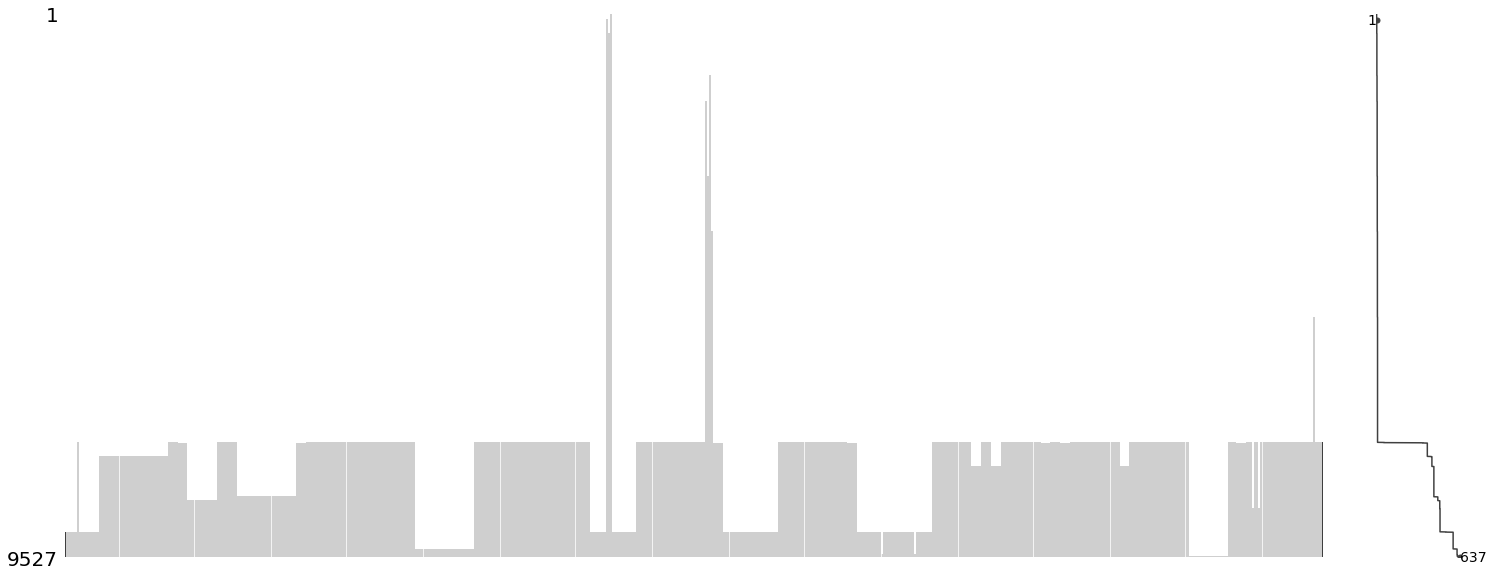

In [48]:
# Count columns and rows that are missing values
print(len(df.columns[df.isna().any()].tolist()),"of", len(df.columns),"columns that have at least one NaN value" )
print(df.isnull().any(axis=1).sum(), "of", df.any(axis=1).sum(), "rows have at least one NaN")

# Visualize the missing values (missing = white)
msno.matrix(df)

In [49]:
# Find the date range where the majority of datasets has values
# We'll print the counts for each value as a starting point for the feature. Because we cannot accurately back fill data we decide to limit our timeline to only the portion that contains data.
fvi = df.apply(pd.Series.first_valid_index)
print("Distinct values for the first valid index are:")
print(fvi.value_counts())

lvi = df.apply(pd.Series.last_valid_index)
print("\nDistinct values for the last valid index are:")
print(lvi.value_counts())

Distinct values for the first valid index are:
2015-01-02 00:00:00+00:00    225
2015-01-01 00:00:00+00:00     65
2020-11-20 00:00:00+00:00     52
2014-12-25 00:00:00+00:00     50
2020-11-13 00:00:00+00:00     46
2015-01-09 00:00:00+00:00     35
2015-11-30 00:00:00+00:00     25
2022-07-01 00:00:00+00:00     20
2022-01-01 00:00:00+00:00     15
2018-08-01 00:00:00+00:00     15
2018-08-03 00:00:00+00:00     15
2022-01-03 00:00:00+00:00     15
2016-08-01 00:00:00+00:00     15
2018-11-01 00:00:00+00:00     10
2015-12-04 00:00:00+00:00      5
2015-01-06 00:00:00+00:00      5
2015-12-01 00:00:00+00:00      5
2018-11-02 00:00:00+00:00      5
2019-05-16 00:00:00+00:00      2
2020-11-18 00:00:00+00:00      2
2022-05-20 00:00:00+00:00      2
2000-09-27 00:00:00+00:00      1
1986-06-02 00:00:00+00:00      1
1990-04-02 00:00:00+00:00      1
1997-01-07 00:00:00+00:00      1
1992-01-01 00:00:00+00:00      1
1986-01-02 00:00:00+00:00      1
1987-05-20 00:00:00+00:00      1
2006-06-14 00:00:00+00:00    

289 of 637 columns that have at least one NaN value
1992 of 2008 rows have at least one NaN


<AxesSubplot:>

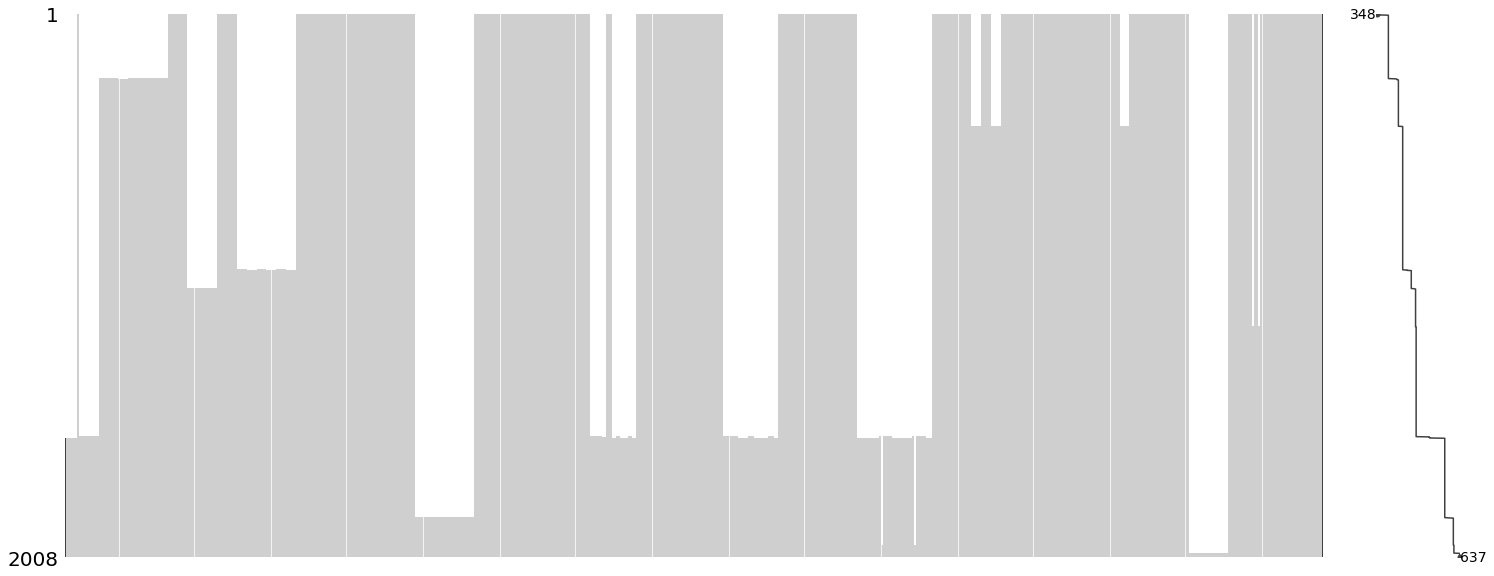

In [50]:
# Limit data set to start where most columns have data and end where most stop having data.
# This limits the amount of extrapolation needed in the final processing step
df = df[(df.index >= fvi.value_counts().idxmax()) & (df.index <= lvi.value_counts().idxmax())]

# Count columns and rows that are missing values
print(len(df.columns[df.isna().any()].tolist()),"of", len(df.columns),"columns that have at least one NaN value" )
print(df.isnull().any(axis=1).sum(), "of", df.any(axis=1).sum(), "rows have at least one NaN")

# Visualize missing values in the new dataset range
msno.matrix(df)

40 of 388 columns that have at least one NaN value
5 of 2008 rows have at least one NaN


<AxesSubplot:>

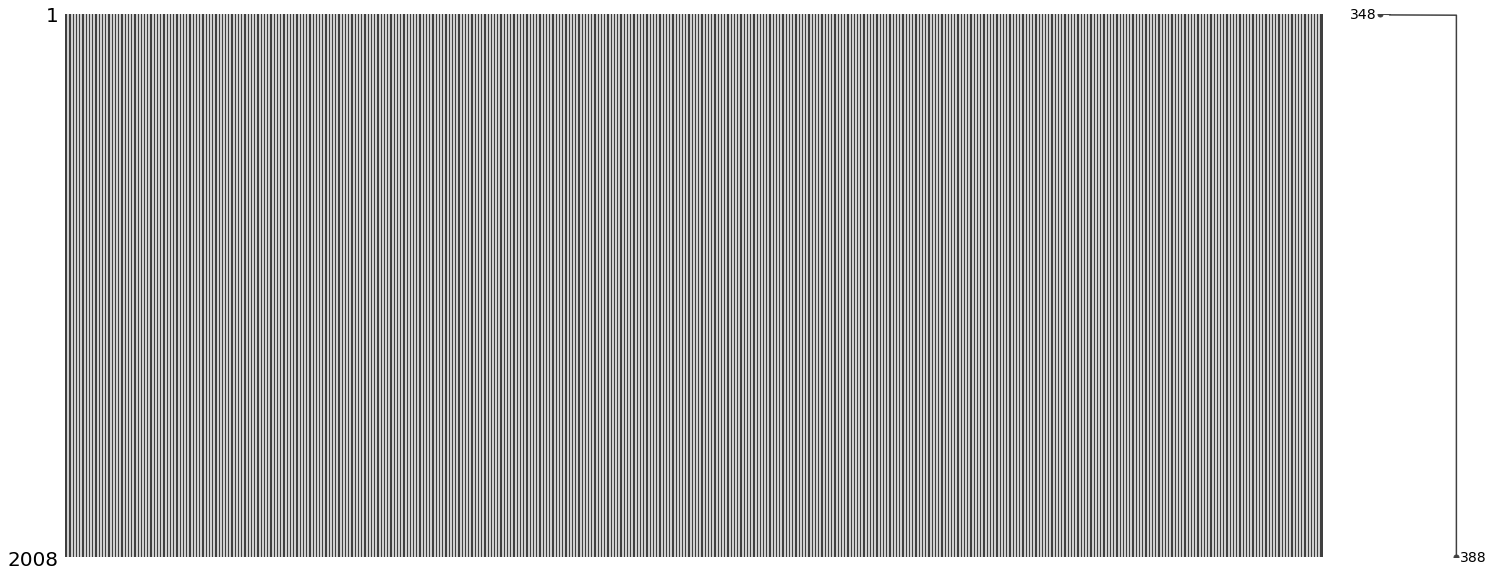

In [51]:
# Indescriminately remove columns if they have more than _threshold_ NaN values
threshold = 0.09 
df = df[df.columns[df.isnull().mean() < threshold]]

# Count columns and rows that are missing values
print(len(df.columns[df.isna().any()].tolist()),"of", len(df.columns),"columns that have at least one NaN value" )
print(df.isnull().any(axis=1).sum(), "of", df.any(axis=1).sum(), "rows have at least one NaN")

# Visualize dataset NaN values
msno.matrix(df)

40 columns have NaN values remaining. Their names are stored in nancols
40 of 388 columns that have at least one NaN value
5 of 2008 rows have at least one NaN


<AxesSubplot:>

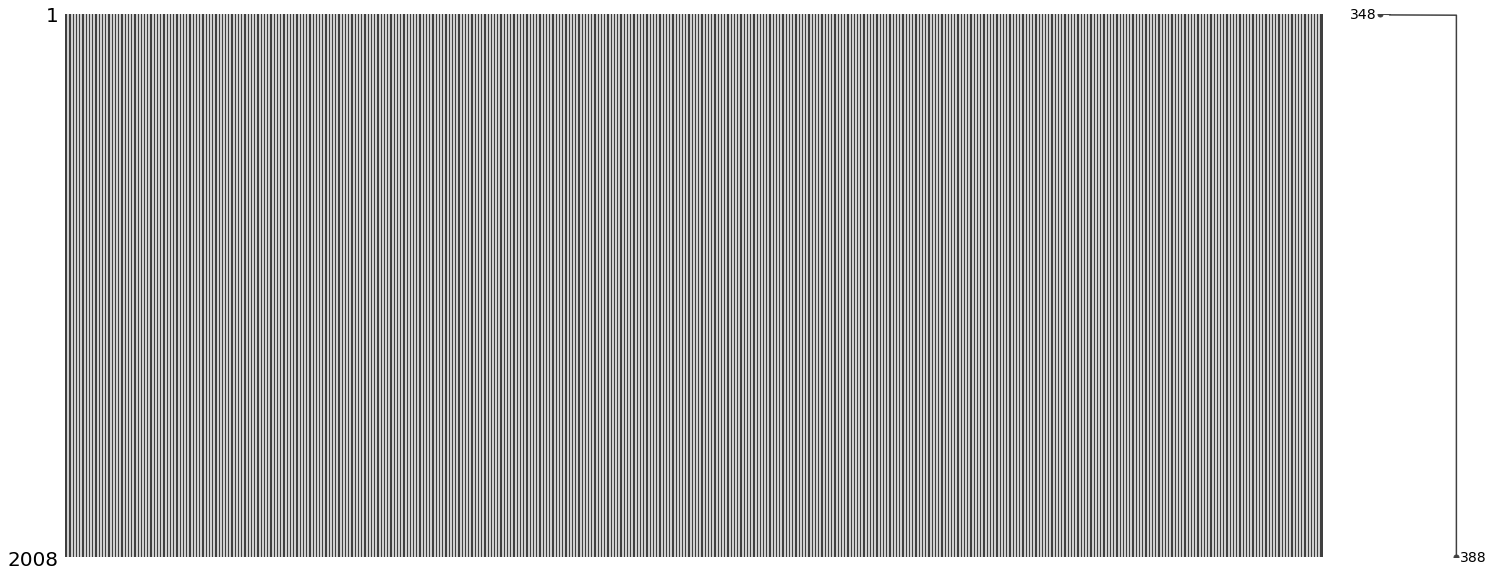

In [52]:
# Get column names that still have missing values, these are about to be extrapolated and we may need to refere back to what data was modified
nancols = df.columns[df.isna().any()].tolist()
print(len(nancols), "columns have NaN values remaining. Their names are stored in nancols")

# Extrapolate missing values using a second order spline (it should be accurate enough to predict values while retaining some naivity)
#df = df.interpolate(method='spline', order=2, limit_direction='forward') # Bad fit for ~6 features
#df = df.interpolate(method='spline', order=1, limit_direction='forward') # Bad fit for fewer than 2nd order Spline
#df = df.interpolate(method='pchip', limit_direction='forward') # Very bad fit
df = df.interpolate(method='ffill', limit_direction='forward') # Linear is the only method that will allow an extrapolation reliably

# Count columns and rows that are missing values
print(len(df.columns[df.isna().any()].tolist()),"of", len(df.columns),"columns that have at least one NaN value" )
print(df.isnull().any(axis=1).sum(), "of", df.any(axis=1).sum(), "rows have at least one NaN")

# Visualize missing values
msno.matrix(df)

In [53]:
# Validate that all features are fully populated
# All columns should have the same first and last indices

fvi = df.apply(pd.Series.first_valid_index)
print("Distinct values for the first valid index are:")
print(fvi.value_counts())

#Iteratively remove rows until all features contain data
while len(fvi.value_counts()) > 1:
    df = df[df.index >= fvi.value_counts().idxmin()]
    fvi = df.apply(pd.Series.first_valid_index)
    print("min value count idx", fvi.value_counts().idxmin())
    print("\nRe-processed values for the first valid index are:\n", fvi.value_counts())

lvi = df.apply(pd.Series.last_valid_index)
print("\nDistinct values for the last valid index are:")
print(lvi.value_counts())

Distinct values for the first valid index are:
2015-01-02 00:00:00+00:00    348
2015-01-09 00:00:00+00:00     35
2015-01-06 00:00:00+00:00      5
dtype: int64
min value count idx 2015-01-09 00:00:00+00:00

Re-processed values for the first valid index are:
 2015-01-06 00:00:00+00:00    353
2015-01-09 00:00:00+00:00     35
dtype: int64
min value count idx 2015-01-09 00:00:00+00:00

Re-processed values for the first valid index are:
 2015-01-09 00:00:00+00:00    388
dtype: int64

Distinct values for the last valid index are:
2022-07-22 00:00:00+00:00    388
dtype: int64


In [54]:
# Test for NaN, inf, or -inf values in dataframe

nan_vals = df.isna().sum().sum()
print('There are', nan_vals,'NaN in df')
inf_vals = df.isin([np.inf, -np.inf]).sum().sum()
print('There are',inf_vals,'inf or -inf values in df')

There are 0 NaN in df
There are 0 inf or -inf values in df


#### 12.2 Resample and Lag Data

To perform Time Series (TS) analysis we shift our predictors vs our target. The function 'lagger' performs a lead on the prediction columns.

'lag_limit' columns are created for each Feature. Each column created is led by 'lag_delta' of the previous step. So lag_delta=1, lag_limit=2 would create a column pushed forward for 1 and 2 days. The allows us to fit the Target to the predictor values yesterday and the day before. Adjusting lag_delta=7, lag_limit=13 creates 3 months worth of weekly shifts so that we predict today's Target using 1, 2, 3, ... 13 week ago data. This will ultimately allow us to predict 3 months into the future using todays known Predcitor values.

##### 12.2.1 Resample Data

In [55]:
# Resample df to only 1 value per week (default is Sunday but doesn't matter and should ensure an aggregate of every week is accurate)
df = df.resample('w').mean()
df.head(10)

,AUD/USD,Benzene CFR Taiwan MAvg (USD/MT)-AVERAGE,Benzene CFR Taiwan MAvg (USD/MT)-CLOSE,Benzene CFR Taiwan MAvg (USD/MT)-HIGH,Benzene CFR Taiwan MAvg (USD/MT)-HIGHLOW2,Benzene CFR Taiwan MAvg (USD/MT)-LOW,Benzene CFR Taiwan Weekly (USD/MT)-AVERAGE,Benzene CFR Taiwan Weekly (USD/MT)-CLOSE,Benzene CFR Taiwan Weekly (USD/MT)-HIGH,Benzene CFR Taiwan Weekly (USD/MT)-HIGHLOW2,...,USD/SGD,USD/THB,USD/TWD,USD/VEB,USD/ZAR,Ultra Low Sulfur No 2 Diesel Fuel Prices US Gulf Coast,"Xylenes (mixed)-Spot, Current Month, High-N/A-Cents per Gallon-Houston, TX-North America","Xylenes (mixed)-Spot, Current Month, Low-N/A-Cents per Gallon-Houston, TX-North America","Xylenes (mixed)-Spot, Next Month, High-N/A-Cents per Gallon-Houston, TX-North America","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America"
date,,,,,,,,,,,,,,,,,,,,,
2015-01-11 00:00:00+00:00,0.819100,614.000000,0.0,615.000000,614.000000,613.000,590.000000,590.000000,591.000000,590.000000,...,1.333700,32.850000,31.890,6.2842,11.485000,1.536000,1652.000,1565.200,1675.20,1580.80
2015-01-18 00:00:00+00:00,0.817960,614.000000,0.0,615.000000,614.000000,613.000,587.000000,587.000000,588.000000,587.000000,...,1.331360,32.750000,31.722,6.2842,11.512100,1.484000,1618.400,1535.280,1658.56,1549.44
2015-01-25 00:00:00+00:00,0.810120,614.000000,0.0,615.000000,614.000000,613.000,597.800000,597.800000,598.800000,597.800000,...,1.335680,32.580000,31.434,6.2842,11.497900,1.525200,1584.800,1497.856,1629.76,1511.84
2015-02-01 00:00:00+00:00,0.785467,623.625000,0.0,624.625000,623.625000,622.625,660.000000,660.000000,661.000000,660.000000,...,1.348700,32.641667,31.435,6.2842,11.561333,1.571833,1645.000,1547.320,1636.00,1571.60
2015-02-08 00:00:00+00:00,0.778520,671.750000,0.0,672.750000,671.750000,670.750,614.200000,614.200000,615.200000,614.200000,...,1.348320,32.598000,31.530,6.2842,11.426700,1.738200,1715.840,1624.000,1722.88,1631.44
2015-02-15 00:00:00+00:00,0.776840,671.750000,0.0,672.750000,671.750000,670.750,663.200000,663.200000,664.200000,663.200000,...,1.356020,32.616000,31.484,6.2842,11.696700,1.825400,1807.680,1729.280,1881.92,1702.08
2015-02-22 00:00:00+00:00,0.780180,671.750000,0.0,672.750000,671.750000,670.750,664.000000,664.000000,665.000000,664.000000,...,1.357460,32.570000,31.622,6.2842,11.637700,1.887800,1905.888,1818.496,1976.80,1815.20
2015-03-01 00:00:00+00:00,0.782483,687.604167,0.0,688.583333,687.604167,686.625,674.666667,674.666667,675.666667,674.666667,...,1.358383,32.440000,31.520,6.2842,11.580083,1.859000,1956.360,1860.120,1983.00,1880.80
2015-03-08 00:00:00+00:00,0.778320,766.875000,0.0,767.750000,766.875000,766.000,714.900000,714.900000,715.800000,714.900000,...,1.368920,32.418000,31.440,6.2842,11.841600,1.831400,1989.200,1924.480,2039.04,1919.76


##### 12.2.2 Test for correlations before lagging

In [56]:
#correlated_features = set()
#correlation_matrix = df.drop(target, axis=1).corr()

#for i in range(len(correlation_matrix.columns)):
#    for j in range(i):
#        if abs(correlation_matrix.iloc[i, j]) > .8:
#            colname = correlation_matrix.columns[i]
#            correlated_features.add(colname)

#print('# Features in df:',len(df.columns),'\n# correlated features:',len(correlated_features))

##### 12.2.3 Lag Data

In [57]:
# Data has been resampled to be weekly so we lag by 1 week for a limit of 13 weeks (~3 months)
df, odf = lagger(df, lag_delta=1, lag_limit=13)
# df = lagged columns in real values
# odf = original columns only, no lags

Original df shape: (394, 388)


c:\Users\baanders\Documents\Benzene Forecasting\Scripts\Functions\ModelingTools.py:55: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



Lagged df shape (with NaN): (394, 5432)
Lagged df shape (without NaN): (381, 5432)
There are 0 NaN values remaining


In [58]:
# Validate one column exists as intended
[col for col in df if col.startswith('Benzene-Spot, Current Month, High')]
[col for col in df if col.startswith('Henry')]

['Henry Hub Natural Gas Spot Price',
 'Henry Hub Natural Gas Spot Price_lag_1',
 'Henry Hub Natural Gas Spot Price_lag_2',
 'Henry Hub Natural Gas Spot Price_lag_3',
 'Henry Hub Natural Gas Spot Price_lag_4',
 'Henry Hub Natural Gas Spot Price_lag_5',
 'Henry Hub Natural Gas Spot Price_lag_6',
 'Henry Hub Natural Gas Spot Price_lag_7',
 'Henry Hub Natural Gas Spot Price_lag_8',
 'Henry Hub Natural Gas Spot Price_lag_9',
 'Henry Hub Natural Gas Spot Price_lag_10',
 'Henry Hub Natural Gas Spot Price_lag_11',
 'Henry Hub Natural Gas Spot Price_lag_12',
 'Henry Hub Natural Gas Spot Price_lag_13']

In [59]:
# Verify that lagger didn't create any un-reconciled NaN, inf, or -inf values.
nan_vals = df.isna().sum().sum()
print('There are', nan_vals,'NaN in df')
inf_vals = df.isin([np.inf, -np.inf]).sum().sum()
print('There are',inf_vals,'inf or -inf values in df')

There are 0 NaN in df
There are 0 inf or -inf values in df


In [60]:
df.head(3)

,AUD/USD,Benzene CFR Taiwan MAvg (USD/MT)-AVERAGE,Benzene CFR Taiwan MAvg (USD/MT)-CLOSE,Benzene CFR Taiwan MAvg (USD/MT)-HIGH,Benzene CFR Taiwan MAvg (USD/MT)-HIGHLOW2,Benzene CFR Taiwan MAvg (USD/MT)-LOW,Benzene CFR Taiwan Weekly (USD/MT)-AVERAGE,Benzene CFR Taiwan Weekly (USD/MT)-CLOSE,Benzene CFR Taiwan Weekly (USD/MT)-HIGH,Benzene CFR Taiwan Weekly (USD/MT)-HIGHLOW2,...,"Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_4","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_5","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_6","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_7","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_8","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_9","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_10","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_11","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_12","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_13"
date,,,,,,,,,,,,,,,,,,,,,
2015-04-12 00:00:00+00:00,0.76796,833.3,0.0,834.2,833.3,832.4,780.0,780.0,781.0,780.0,...,1953.28,1919.76,1880.80,1815.20,1702.08,1631.44,1571.60,1511.84,1549.44,1580.80
2015-04-19 00:00:00+00:00,0.76798,833.3,0.0,834.2,833.3,832.4,816.6,816.6,817.6,816.6,...,1796.28,1953.28,1919.76,1880.80,1815.20,1702.08,1631.44,1571.60,1511.84,1549.44
2015-04-26 00:00:00+00:00,0.77692,833.3,0.0,834.2,833.3,832.4,870.1,870.1,871.0,870.1,...,1687.70,1796.28,1953.28,1919.76,1880.80,1815.20,1702.08,1631.44,1571.60,1511.84


### 12.5 Visualize the data

In [61]:
print('First Data Point:', df.index[0])
print('Last Data Point:', df.index[-1])
print('Count of Features:', df.columns.shape[0])

First Data Point: 2015-04-12 00:00:00+00:00
Last Data Point: 2022-07-24 00:00:00+00:00
Count of Features: 5432


In [62]:
# Visualize only the columns that had NaN values to be extrapolated
#multi_plot(df, title="Full Dataset Visualization")

### 12.6 Export Data

In [63]:
# Define default storage location for files
edataroot = '../../Data/Parquet/SKLearn Data/'
csvdataroot = '../../Data/CSV/SKLearn Data/'
ifilename = dt.date.today().strftime('%Y%m%d') + '_weekly'

parquet_path = edataroot+'weekly_for_modeling.parquet'
print(f'parquet file will write to: {parquet_path}')

run_date = date.today().strftime('%Y-%m-%d')
print(f'Log will be created for: {run_date}')

parquet file will write to: ../../Data/Parquet/SKLearn Data/weekly_for_modeling.parquet
Log will be created for: 2022-07-24


In [64]:
# Create multi-index verson of df for parquet file
df_p = pd.concat([df],  keys=[run_date], names=['run_date'], axis=1)

In [65]:
df_p.head(2)

run_date                  2022-07-24                                           \
                             AUD/USD Benzene CFR Taiwan MAvg (USD/MT)-AVERAGE   
date                                                                            
2015-04-12 00:00:00+00:00    0.76796                                    833.3   
2015-04-19 00:00:00+00:00    0.76798                                    833.3   

run_date                                                          \
                          Benzene CFR Taiwan MAvg (USD/MT)-CLOSE   
date                                                               
2015-04-12 00:00:00+00:00                                    0.0   
2015-04-19 00:00:00+00:00                                    0.0   

run_date                                                         \
                          Benzene CFR Taiwan MAvg (USD/MT)-HIGH   
date                                                              
2015-04-12 00:00:00+00:00                                 834.2   
2015-04-19 00:00:00+00:00                                 834.2   

run_date                                                             \
                          Benzene CFR Taiwan MAvg (USD/MT)-HIGHLOW2   
date                                                                  
2015-04-12 00:00:00+00:00                                     833.3   
2015-04-19 00:00:00+00:00                                     833.3   

run_date                                                        \
                          Benzene CFR Taiwan MAvg (USD/MT)-LOW   
date                                                             
2015-04-12 00:00:00+00:00                                832.4   
2015-04-19 00:00:00+00:00                                832.4   

run_date                                                              \
                          Benzene CFR Taiwan Weekly (USD/MT)-AVERAGE   
date                                                                   
2015-04-12 00:00:00+00:00                                      780.0   
2015-04-19 00:00:00+00:00                                      816.6   

run_date                                                            \
                          Benzene CFR Taiwan Weekly (USD/MT)-CLOSE   
date                                                                 
2015-04-12 00:00:00+00:00                                    780.0   
2015-04-19 00:00:00+00:00                                    816.6   

run_date                                                           \
                          Benzene CFR Taiwan Weekly (USD/MT)-HIGH   
date                                                                
2015-04-12 00:00:00+00:00                                   781.0   
2015-04-19 00:00:00+00:00                                   817.6   

run_date                                                               ...  \
                          Benzene CFR Taiwan Weekly (USD/MT)-HIGHLOW2  ...   
date                                                                   ...   
2015-04-12 00:00:00+00:00                                       780.0  ...   
2015-04-19 00:00:00+00:00                                       816.6  ...   

run_date                                                                                                              \
                          Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_4   
date                                                                                                                   
2015-04-12 00:00:00+00:00                                            1953.28                                           
2015-04-19 00:00:00+00:00                                            1796.28                                           

run_date                                                                                                              \
                          Xylenes (mixed)-Spot, Next Month, 

In [66]:
# Export appended parquet file

# Load current history and append new entries
if Path(parquet_path).is_file():
    print('Appending to current file')
    data_hist = pd.read_parquet(parquet_path)
    data_hist = pd.concat([data_hist, df_p], axis=1, ignore_index=False)
    data_hist.to_parquet(path=parquet_path, engine='pyarrow', compression=None, index=True)
else:
    print('Created new file')
    data_hist = df_p # No current history so set it to current df values
    data_hist.to_parquet(path=parquet_path, engine='pyarrow', compression=None, index=True)

Created new file


In [67]:
# Export CSV file
if os.path.isdir(csvdataroot):
    # Export Data
    df.to_csv(csvdataroot+ifilename+'_for_modeling.csv')
    print(ifilename+' dataset exported to ', csvdataroot+ifilename+'_for_modeling.csv')
else:
    os.mkdir(csvdataroot)
    print('CSV storage location did not exist. It has been created\n')
    df.to_csv(csvdataroot+ifilename+'_for_modeling.csv')
    print(ifilename+' dataset exported to ', csvdataroot+ifilename+'_for_modeling.csv')

20220724_weekly dataset exported to  ../../Data/CSV/SKLearn Data/20220724_weekly_for_modeling.csv
